# Laboratorio 3 - Deep Learning / Redes Neuronales

### Sebastian Juárez 21471
Link al repo: https://github.com/SebasJuarez/DS-Collection/tree/Lab3

## Analisis Exploratorio

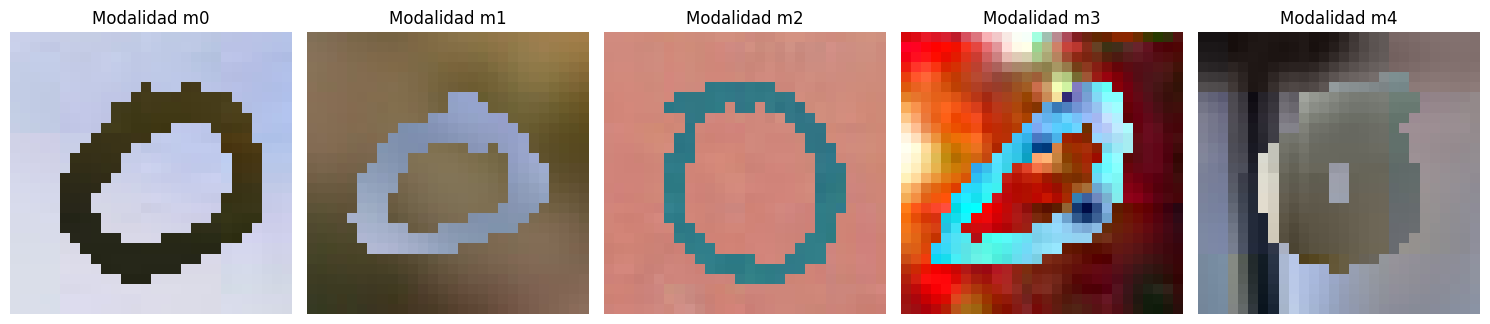

In [55]:
import os
import matplotlib.pyplot as plt
from PIL import Image

base_path = ".\\Data\\Poly\\PolyMNIST\\MMNIST\\train"

modalidades = ["m0", "m1", "m2", "m3", "m4"]

fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, modalidad in enumerate(modalidades):
    img_path = os.path.join(base_path, modalidad, "0.0.png")
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Modalidad {modalidad}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [56]:
from PIL import Image
import pandas as pd

conteo = {"modalidad": [], "train_imgs": [], "test_imgs": [], "resolucion": []}

for modalidad in modalidades:
    train_dir = os.path.join(base_path, modalidad)
    # Cambia base_path de train a test para test_dir
    test_base_path = base_path.replace("train", "test")
    test_dir = os.path.join(test_base_path, modalidad)

    train_imgs = os.listdir(train_dir)
    test_imgs = os.listdir(test_dir)

    # Tomar una imagen para verificar resolución
    sample_img = Image.open(os.path.join(train_dir, train_imgs[0]))
    resolucion = sample_img.size  # (ancho, alto)

    conteo["modalidad"].append(modalidad)
    conteo["train_imgs"].append(len(train_imgs))
    conteo["test_imgs"].append(len(test_imgs))
    conteo["resolucion"].append(f"{resolucion[0]}x{resolucion[1]}")

df_conteo = pd.DataFrame(conteo)
print(df_conteo)


  modalidad  train_imgs  test_imgs resolucion
0        m0       60000      10000      28x28
1        m1       60000      10000      28x28
2        m2       60000      10000      28x28
3        m3       60000      10000      28x28
4        m4       60000      10000      28x28


## Division de imagenes

In [57]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PolyMNISTDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.img_names = [f for f in os.listdir(folder_path) if f.endswith(".png")]
        self.transform = transform

        # Filtrar solo imágenes con etiquetas válidas (0 a 9)
        self.img_names = [f for f in self.img_names if self._get_label(f) in range(10)]

    def _get_label(self, fname):
        # fname = "1609.4.png" → split = ["1609", "4", "png"]
        return int(fname.split('.')[1])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        label = self._get_label(img_name)
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label



In [58]:
import torchvision.transforms as transforms

# Transformaciones para entrenamiento con augmentations
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Transformaciones para prueba sin augmentations
transform_test = transforms.Compose([
    transforms.ToTensor()
])


In [59]:
# Seleccionamos una modalidad, por ejemplo "m0"
modalidad = "m0"
train_path = f"Data/Poly/PolyMNIST/MMNIST/train/{modalidad}"
test_path  = f"Data/Poly/PolyMNIST/MMNIST/test/{modalidad}"

# Instanciar datasets
train_dataset = PolyMNISTDataset(train_path, transform=transform_train)
test_dataset  = PolyMNISTDataset(test_path, transform=transform_test)


In [60]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Se dividen las imágenes en conjuntos de entrenamiento y prueba para poder entrenar los modelos con una parte de los datos y luego evaluar qué tan bien aprenden usando imágenes nuevas. Esto nos ayuda a saber si el modelo generaliza bien y no solo "memoriza" los ejemplos que ya vio.

## Modelo CNN

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def entrenar_modelo(model, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = correct / total * 100
        print(f"Época {epoch+1}: pérdida = {running_loss:.4f}, accuracy = {acc:.2f}%")

    print("Entrenamiento completo.")


Usando: cpu


In [53]:
def evaluar_modelo(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy en test: {accuracy:.2f}%")


In [54]:
entrenar_modelo(model, train_loader, test_loader, epochs=5)
evaluar_modelo(model, test_loader)


Época 1: pérdida = 1096.7440, accuracy = 60.61%
Época 2: pérdida = 639.4669, accuracy = 78.07%
Época 3: pérdida = 509.0544, accuracy = 82.57%
Época 4: pérdida = 419.1430, accuracy = 85.63%
Época 5: pérdida = 357.3108, accuracy = 87.70%
Entrenamiento completo.
Accuracy en test: 93.56%


## Red Neuronal Simple

In [41]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [42]:
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

entrenar_modelo(model, train_loader, test_loader, epochs=5)
evaluar_modelo(model, test_loader)


Época 1: pérdida = 1909.5798, accuracy = 25.83%
Época 2: pérdida = 1480.4056, accuracy = 46.41%
Época 3: pérdida = 1330.8133, accuracy = 52.49%
Época 4: pérdida = 1241.2734, accuracy = 55.84%
Época 5: pérdida = 1189.0695, accuracy = 57.84%
Entrenamiento completo.
Accuracy en test: 62.85%


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSimpleNN(nn.Module):
    def __init__(self):
        super(ImprovedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

model = ImprovedSimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

entrenar_modelo(model, train_loader, test_loader, epochs=15)
evaluar_modelo(model, test_loader)


Época 1: pérdida = 2096.7534, accuracy = 14.85%
Época 2: pérdida = 1951.4264, accuracy = 22.88%
Época 3: pérdida = 1884.6732, accuracy = 26.01%
Época 4: pérdida = 1839.5458, accuracy = 28.53%
Época 5: pérdida = 1815.9937, accuracy = 29.53%
Época 6: pérdida = 1783.5601, accuracy = 31.20%
Época 7: pérdida = 1755.2956, accuracy = 32.97%
Época 8: pérdida = 1716.1368, accuracy = 34.76%
Época 9: pérdida = 1694.1310, accuracy = 35.94%
Época 10: pérdida = 1670.1448, accuracy = 37.38%
Época 11: pérdida = 1649.6519, accuracy = 38.12%
Época 12: pérdida = 1630.2269, accuracy = 39.47%
Época 13: pérdida = 1604.8552, accuracy = 40.52%
Época 14: pérdida = 1593.6718, accuracy = 41.07%
Época 15: pérdida = 1578.3363, accuracy = 41.68%
Entrenamiento completo.
Accuracy en test: 57.61%


## Desarrollo de otro modelo: Pruebas con KKN

In [ ]:
import numpy as np

def convertir_dataset_para_sklearn(dataset, max_muestras=5000):
    X = []
    y = []
    for i in range(min(len(dataset), max_muestras)):
        img, label = dataset[i]
        X.append(img.view(-1).numpy())
        y.append(label)
    return np.array(X), np.array(y)

X_train_knn, y_train_knn = convertir_dataset_para_sklearn(train_dataset, max_muestras=5000)
X_test_knn, y_test_knn = convertir_dataset_para_sklearn(test_dataset, max_muestras=1000)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preparar_para_knn(train_dataset, test_dataset, n_train=5000, n_test=1000, n_components=100):
    def convertir_dataset(dataset, max_muestras):
        X, y = [], []
        for i in range(min(len(dataset), max_muestras)):
            img, label = dataset[i]
            X.append(img.view(-1).numpy())
            y.append(label)
        return np.array(X), np.array(y)

    X_train_raw, y_train = convertir_dataset(train_dataset, n_train)
    X_test_raw, y_test = convertir_dataset(test_dataset, n_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_test_pca, y_train, y_test

X_train_knn, X_test_knn, y_train_knn, y_test_knn = preparar_para_knn(train_dataset, test_dataset)


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_knn, y_train_knn)
y_pred = knn.predict(X_test_knn)

print(f"Accuracy KNN optimizado: {accuracy_score(y_test_knn, y_pred) * 100:.2f}%")

Accuracy KNN optimizado: 40.60%


Se probó el modelo KNN porque es uno de los métodos más simples y conocidos para clasificación. Aunque no tuvo buenos resultados en este caso, nos sirvió como punto de comparación para ver qué tan importante es usar modelos más avanzados cuando las imágenes tienen ruido o fondos complejos.

## Desarrollo de otro modelo: Pruebas con SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X_train_svm, X_test_svm, y_train_svm, y_test_svm = preparar_para_knn(train_dataset, test_dataset)

svm = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train_svm, y_train_svm)

y_pred_svm = svm.predict(X_test_svm)
acc_svm = accuracy_score(y_test_svm, y_pred_svm)

print(f"Accuracy SVM: {acc_svm * 100:.2f}%")
print(classification_report(y_test_svm, y_pred_svm))


Accuracy SVM: 58.10%
              precision    recall  f1-score   support

           0       0.46      0.80      0.58        79
           1       0.83      0.62      0.71       214
           2       0.58      0.63      0.61       111
           3       0.66      0.43      0.52        89
           4       0.53      0.49      0.51        79
           5       0.54      0.49      0.52        79
           6       0.48      0.69      0.57        78
           7       0.71      0.57      0.63       106
           8       0.37      0.49      0.42        78
           9       0.58      0.54      0.56        87

    accuracy                           0.58      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.61      0.58      0.59      1000



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3] 
}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_svm, y_train_svm)

mejor_svm = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

y_pred = mejor_svm.predict(X_test_svm)
acc = accuracy_score(y_test_svm, y_pred)
print(f"Accuracy con SVM optimizado: {acc * 100:.2f}%")
print(classification_report(y_test_svm, y_pred))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores hiperparámetros encontrados: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy con SVM optimizado: 58.90%
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        79
           1       0.73      0.71      0.72       214
           2       0.72      0.62      0.67       111
           3       0.61      0.43      0.50        89
           4       0.45      0.61      0.52        79
           5       0.49      0.47      0.48        79
           6       0.58      0.68      0.63        78
           7       0.54      0.48      0.51       106
           8       0.44      0.44      0.44        78
           9       0.57      0.54      0.55        87

    accuracy                           0.59      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.60      0.59      0.59      1000



Se hizo otra prueba con este modelo porque es otro metodo bastante basico que funciona bien en muchos problemas de clasificación. A pesar de no ser una red neuronal, nos permitió ver que si es que hay un buen preprocesamiento y ajuste de parámetros, puede tener un rendimiento aceptable, aunque sigue siendo superado por las CNN con un gran margen.

## Comparación de los modelos

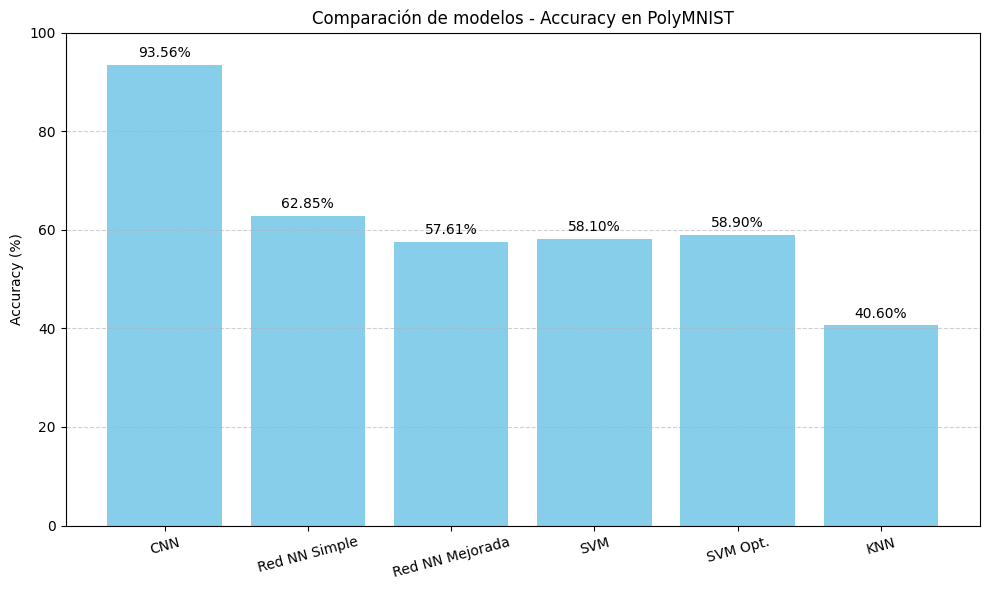

In [62]:
modelos = [
    "CNN",
    "Red NN Simple",
    "Red NN Mejorada",
    "SVM",
    "SVM Opt.",
    "KNN"
]

accuracies = [
    93.56,
    62.85,
    57.61,
    58.10,
    58.90,
    40.60
]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, accuracies, color='skyblue')
plt.title("Comparación de modelos - Accuracy en PolyMNIST")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{acc:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


En este laboratorio probamos varios modelos para reconocer dígitos escritos a mano usando imágenes del dataset PolyMNIST, que comparados a otros datasets, este es bastante mas difícil ya que hay mucho ruido que puede llegar a ser un desafio para ciertos modelos de clasificación.

El modelo que dio los mejores resultados fue la red neuronal convolucional (CNN), con una precisión del 93.56%. Podemos pensar que esto se debe a que las CNN están diseñadas para trabajar con imágenes y pueden aprender patrones visuales como bordes, formas y posiciones, en cambio a todos los otros modelos se les tiene que hacer ciertos ajustes para tratar de mejorar su desempeño.

La red neuronal simple y su versión mejorada (con más capas y dropout) no lograron superar el 63% de precisión. Esto confirma que las redes densas no son buenas para procesar imágenes complejas y esto se puede atribuir a que este modelo no puede entender ciertas estructuras de los pixeles.

También probamos modelos más tradicionales como KNN y SVM, que son fáciles de implementar. El SVM tuvo un desempeño aceptable (~59%) después de ajustar sus parámetros, pero aún quedó lejos del resultado de la CNN. KNN fue el modelo con menor precisión ya que si se vio afectado por el ruido del fondo de las imagenes.